# Data_Augmentation

- Scale
- Crop
- Flip
- Rotate (using PIL Transform )

## 1. Settings
### 1) Import required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [4]:
batch_size = 16
learning_rate = 0.0002
num_epoch = 2

## 2. Data

### 1) Download Data

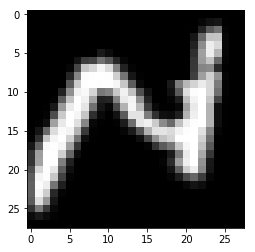

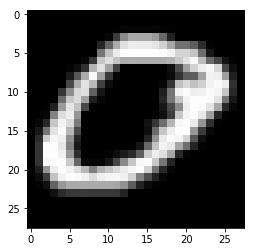

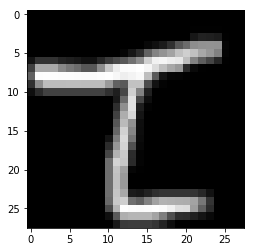

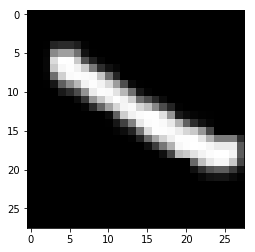

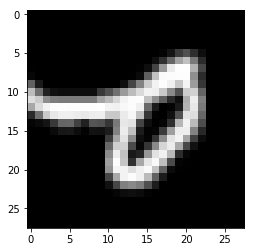

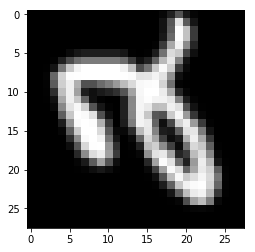

In [16]:
mnist_train = dset.MNIST("./", train=True, 
                         transform = transforms.Compose([
                             transforms.Scale(34),
                             transforms.CenterCrop(28),
                             transforms.RandomHorizontalFlip(),
                             transforms.Lambda(lambda x: x.rotate(90)),
                             #transforms.ToTensor(),
                         ]),
                         target_transform=None,
                         download=True)



mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

for _,(i,j) in enumerate(mnist_train):
    plt.imshow(i,cmap="gray")
    plt.show()
    if _ == 5:
        break

### 2) Check Dataset

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

torch.Size([1, 28, 28]) 60000


(torch.Size([1, 28, 28]), 10000)

### 3) Set DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. Model & Optimizer

### 1) CNN Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 14
            nn.Conv2d(32,64,3,padding=1), #14
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        #print(out.size())
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

model = CNN().cuda()

### 2) Loss func & Optimizer

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 4. Train 

In [8]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)          

Variable containing:
 2.3047
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.3095
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.3174
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.2934
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.3028
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.3028
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.3088
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.2947
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [9]:
#param_list = list(model.parameters())
#print(param_list)

## 5. Test

In [10]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True).cuda()
    y_= Variable(label).cuda()

    output = model.forward(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: Variable containing:
 17.5600
[torch.cuda.FloatTensor of size 1 (GPU 0)]

